# Исследование данных стримингового сервиса

Представлена упрощённая модель данных стримингового сервиса

#### Задача: 
Посмотреть, если ли сезонность в покупке треков разных жанров.

#### Исходные данные: - файл chinook.db 

#### Порядок реализации:
- Создать подключение к базе данных и сформировать запрос в результате которого получится таблица, содержащая:
    - данные о чеках (invoice): id, дату;
    - id покупателя и id всех треков в чеке;
    - жанр каждого трека: объедините все тяжёлые жанры (Rock, Alternative & Punk, Metal, Alternative, Heavy Metal) в категорию ‘rock’, а остальные жанры — в категорию ‘others’;
    - стоимость трека,
    - в таблицу должны попасть данные только по аудиофайлам (media_type) за 2020 год 
- На основе запроса создать датафрейм (read_sql_query) в pandas
- Проверить датафрейм на пропуски и дубликаты (если они есть, предположить их происхождение и решить, нужно ли их обрабатывать
- Привести дату к первому числу каждого месяца
- Сгруппировать данные, и через seaborn построить графики, чтобы оценить по категориям жанров (‘rock’ и ‘others’) следующие ежемесячные показатели:
    - общее количество купленных треков,
    - число чеков,
    - число покупателей,
    - общую стоимость треков.
- Должно получиться три графика, где на каждом присутствуют обе категории и ежемесячные показатели по ним
- Сделать выводы по имеющимся данным

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import re
import datetime
import matplotlib.pyplot as plt

### 1. Подключение к базе, формирование запроса и сохранение результата в датафрейм

In [2]:
# Подключаемся к базе данных
dbfile = 'chinook.db'
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

In [3]:
# Смотрим на состав данных в базе данных, выводим перечень столбцов
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name : {cursor.fetchall()}")

Table Name : [('album',), ('artist',), ('customer',), ('employee',), ('genre',), ('invoice',), ('invoice_line',), ('media_type',), ('playlist',), ('playlist_track',), ('track',)]


In [4]:
# Или таким способом
table_list = [a for a in cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
print(table_list)

[('album',), ('artist',), ('customer',), ('employee',), ('genre',), ('invoice',), ('invoice_line',), ('media_type',), ('playlist',), ('playlist_track',), ('track',)]


In [ ]:
# Создаем запрос в БД на заданные данные, закрываем подключение к БД
result_ = [a for a in cursor.execute("SELECT invoice_id, invoice_date, customer_id, c.track_id, genre_type, c.unit_price \
                                      FROM \
                                        (SELECT a.invoice_id, invoice_date, customer_id, track_id, unit_price \
                                          FROM \
                                            (SELECT invoice_id, invoice_date, customer_id \
                                             FROM invoice \
                                               WHERE strftime('%Y', invoice_date) == '2020') AS a \
                                             JOIN (SELECT * from invoice_line) AS b \
                                             ON a.invoice_id = b.invoice_id) AS c \
                                          JOIN \
                                             (SELECT * \
                                             FROM track as a \
                                             JOIN (SELECT * FROM media_type \
                                                   WHERE name LIKE '%audio%')as b \
                                             ON a.media_type_id== b.media_type_id \
                                             JOIN (SELECT *,\
                                                      CASE    \
                                                        WHEN name = 'Rock' OR name = 'Alternative & Punk' OR name = 'Metal' \
                                                        OR name = 'Alternative' OR name = 'Heavy Metal' THEN 'rock'\
                                                        ELSE 'others’' \
                                                      END AS genre_type \
                                                    FROM genre) as c \
                                             ON a.genre_id== c.genre_id) AS d \
                                          ON c.track_id = d.track_id   \
                                     ")]
print(len(result_))

In [6]:
# На основе запроса создаем такой же датафрейм, закрываем подключение к БД
df = pd.read_sql_query("SELECT invoice_id, invoice_date, customer_id, c.track_id, genre_type, c.unit_price \
                                      FROM \
                                        (SELECT a.invoice_id, invoice_date, customer_id, track_id, unit_price \
                                          FROM \
                                            (SELECT invoice_id, invoice_date, customer_id \
                                             FROM invoice \
                                               WHERE strftime('%Y', invoice_date) == '2020') AS a \
                                             JOIN (SELECT * from invoice_line) AS b \
                                             ON a.invoice_id = b.invoice_id) AS c \
                                          JOIN \
                                             (SELECT * \
                                             FROM track as a \
                                             JOIN (SELECT * FROM media_type \
                                                   WHERE name LIKE '%audio%')as b \
                                             ON a.media_type_id== b.media_type_id \
                                             JOIN (SELECT *,\
                                                      CASE    \
                                                        WHEN name = 'Rock' OR name = 'Alternative & Punk' OR name = 'Metal' \
                                                        OR name = 'Alternative' OR name = 'Heavy Metal' THEN 'rock'\
                                                        ELSE 'others’' \
                                                      END AS genre_type \
                                                    FROM genre) as c \
                                             ON a.genre_id== c.genre_id) AS d \
                                          ON c.track_id = d.track_id \
                     ", conn)
conn.close()

In [7]:
print(df.shape)
df.head()

(1150, 6)


,invoice_id,invoice_date,customer_id,track_id,genre_type,unit_price
0,465,2020-01-12 00:00:00,21,149,rock,0.99
1,465,2020-01-12 00:00:00,21,150,rock,0.99
2,465,2020-01-12 00:00:00,21,151,rock,0.99
3,465,2020-01-12 00:00:00,21,152,rock,0.99
4,465,2020-01-12 00:00:00,21,153,rock,0.99


### 2. Оценка датафрейма на состоятельность, EDA

#### 2.1.  Проверка датафрейма на пропуски и дубликаты

<AxesSubplot:>

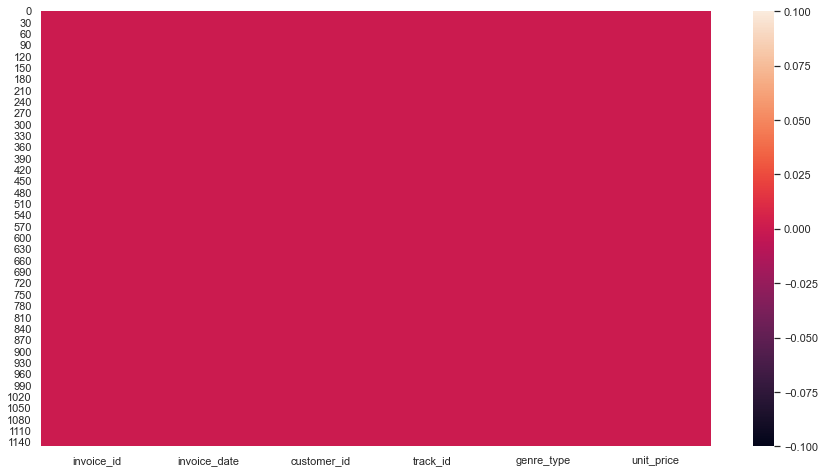

In [9]:
# Проверяем на пропуски через тепловую карту
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.isnull())

##### В датафрейме пропусков данных не обнаружено

In [10]:
# Проверяем на дубликаты
duplicateRows = df[df.duplicated ()]
duplicateRows

,invoice_id,invoice_date,customer_id,track_id,genre_type,unit_price
382,517,2020-05-16 00:00:00,3,2573,others’,0.99
997,593,2020-11-23 00:00:00,12,1042,others’,0.99


##### В датафрейме установлены 2 строки-дубликата. Они в данном случае могут возникнуть из-за того, что покупатель ошибочно дважды произвел покупку одного и того же трека. Удалять их нельзя, т.к. покупка состоялась и удаление повторных строк даст неверный результат по общей сумме покупок в базе.

#### 2.2.  Приведение даты к первому числу каждого месяца

In [11]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['invoice_date_01'] = df['invoice_date'].dt.strftime('%Y-%m-01')
df

,invoice_id,invoice_date,customer_id,track_id,genre_type,unit_price,invoice_date_01
0,465,2020-01-12,21,149,rock,0.99,2020-01-01
1,465,2020-01-12,21,150,rock,0.99,2020-01-01
2,465,2020-01-12,21,151,rock,0.99,2020-01-01
3,465,2020-01-12,21,152,rock,0.99,2020-01-01
4,465,2020-01-12,21,153,rock,0.99,2020-01-01
...,...,...,...,...,...,...,...
1145,614,2020-12-30,53,2659,rock,0.99,2020-12-01
1146,614,2020-12-30,53,2660,rock,0.99,2020-12-01
1147,614,2020-12-30,53,2661,rock,0.99,2020-12-01
1148,614,2020-12-30,53,2662,rock,0.99,2020-12-01


#### 2.3.  Группировка данных, построение графиков

Графики, чтобы оценить по категориям жанров (‘rock’ и ‘others’) ежемесячные показатели:
- общее количество купленных треков,
- число чеков,
- число покупателей,
- общую стоимость треков

In [17]:
df_invoice

,invoice_date_01,genre_type,invoice_id,invoice_count
0,2020-01-01,others’,466,1
10,2020-01-01,rock,472,2
9,2020-01-01,rock,471,1
7,2020-01-01,rock,469,1
6,2020-01-01,rock,468,16
...,...,...,...,...
202,2020-12-01,others’,601,3
201,2020-12-01,others’,599,1
222,2020-12-01,rock,613,7
211,2020-12-01,rock,601,8


In [18]:
df_invoice_

,invoice_date_01,genre_type,invoice_count_
0,2020-01-01,others’,3
1,2020-01-01,rock,8
2,2020-02-01,others’,4
3,2020-02-01,rock,11
4,2020-03-01,others’,6
5,2020-03-01,rock,10
6,2020-04-01,others’,8
7,2020-04-01,rock,15
8,2020-05-01,others’,8
9,2020-05-01,rock,13


In [12]:
df_track = df.groupby(['invoice_date_01', 'genre_type'], as_index=False) \
        .agg(track_count=('track_id', 'count')).sort_values(by='invoice_date_01')
df_invoice = df.groupby(['invoice_date_01','genre_type', 'invoice_id'], as_index=False) \
        .agg(invoice_count=('invoice_id', 'count')).sort_values(by='invoice_date_01')
df_invoice_ = df_invoice.groupby(['invoice_date_01','genre_type'], as_index=False) \
        .agg(invoice_count_=('invoice_count', 'count')).sort_values(by='invoice_date_01')
df_customer = df.groupby(['invoice_date_01','genre_type', 'customer_id'], as_index=False) \
        .agg(customer_count=('customer_id', 'count')).sort_values(by='invoice_date_01')
df_customer_ = df_customer.groupby(['invoice_date_01','genre_type'], as_index=False) \
        .agg(customer_count_=('customer_count', 'count')).sort_values(by='invoice_date_01')
df_price = df.groupby(['invoice_date_01','genre_type'], as_index=False) \
        .agg(sum_price=('unit_price', 'sum')).sort_values(by='invoice_date_01')

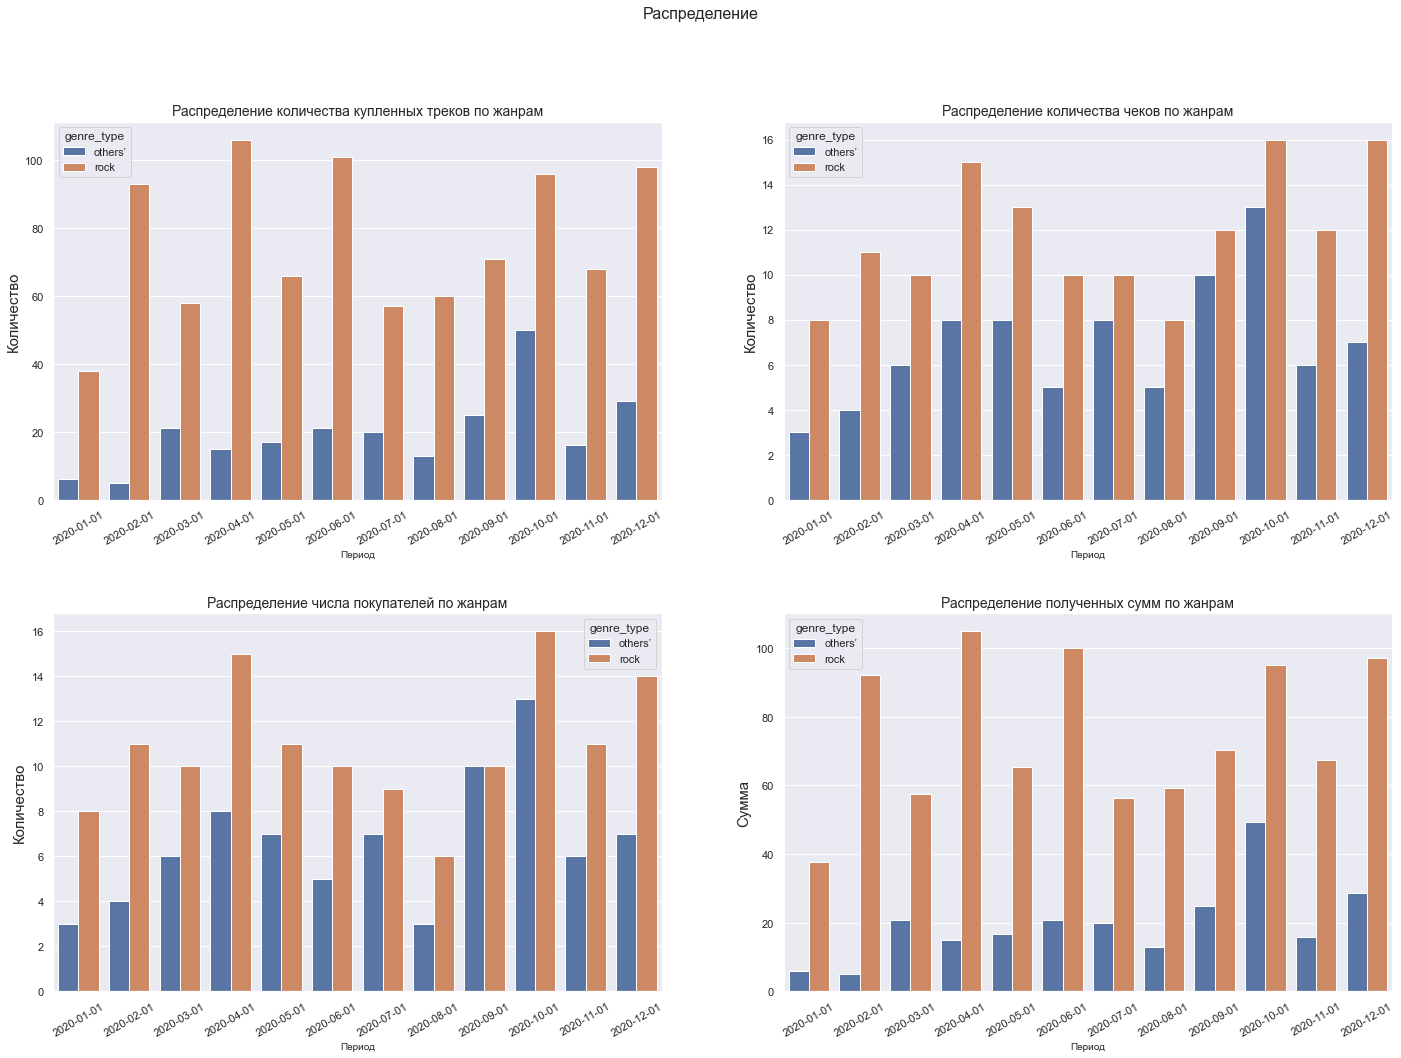

In [14]:
fig, ax = plt.subplots(2, 2,figsize=(24,16))
fig.suptitle('Распределение', fontsize=16)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

sns.barplot(x='invoice_date_01', y='track_count', data = df_track, hue='genre_type', ax = ax[0,0])
ax[0,0].set_title('Распределение количества купленных треков по жанрам', fontsize=14)
ax[0,0].tick_params(axis='x', labelrotation=30)
ax[0,0].set_xlabel('Период', fontsize=10)
ax[0,0].set_ylabel('Количество', fontsize=15)

sns.barplot(x='invoice_date_01', y='invoice_count_', data = df_invoice_, hue='genre_type', ax = ax[0,1])
ax[0,1].set_title('Распределение количества чеков по жанрам', fontsize=14)
ax[0,1].tick_params(axis='x', labelrotation=30)
ax[0,1].set_xlabel('Период', fontsize=10)
ax[0,1].set_ylabel('Количество', fontsize=15)

sns.barplot(x='invoice_date_01', y='customer_count_', data = df_customer_, hue='genre_type', ax = ax[1,0])
ax[1,0].set_title('Распределение числа покупателей по жанрам', fontsize=14)
ax[1,0].tick_params(axis='x', labelrotation=30)
ax[1,0].set_xlabel('Период', fontsize=10)
ax[1,0].set_ylabel('Количество', fontsize=15)

sns.barplot(x='invoice_date_01', y='sum_price', data = df_price, hue='genre_type', ax = ax[1,1])
ax[1,1].set_title('Распределение полученных сумм по жанрам', fontsize=14)
ax[1,1].tick_params(axis='x', labelrotation=30)
ax[1,1].set_xlabel('Период', fontsize=10)
ax[1,1].set_ylabel('Сумма', fontsize=15)

plt.show()

In [15]:
# Таблица количества треков по месяцам
df_track_ = df.groupby(['invoice_date_01'], as_index=False) \
        .agg(track_count=('track_id', 'count')).sort_values(by='invoice_date_01')
df_track_

,invoice_date_01,track_count
0,2020-01-01,44
1,2020-02-01,98
2,2020-03-01,79
3,2020-04-01,121
4,2020-05-01,83
5,2020-06-01,122
6,2020-07-01,77
7,2020-08-01,73
8,2020-09-01,96
9,2020-10-01,146


In [16]:
# Таблица количества покупок покутелями по месяцам
df_invoice1 = df.groupby(['invoice_date_01','invoice_id'], as_index=False) \
        .agg(invoice_count=('invoice_id', 'count')).sort_values(by='invoice_date_01')
df_invoice_1 = df_invoice1.groupby(['invoice_date_01'], as_index=False) \
        .agg(invoice_count_=('invoice_count', 'count')).sort_values(by='invoice_date_01')
df_invoice_1

,invoice_date_01,invoice_count_
0,2020-01-01,8
1,2020-02-01,11
2,2020-03-01,11
3,2020-04-01,16
4,2020-05-01,13
5,2020-06-01,11
6,2020-07-01,12
7,2020-08-01,8
8,2020-09-01,13
9,2020-10-01,18


#### 1. График распределения количества купленных треков и полученных сумм имеют абсолютно идентичные формы. Объясняется это тем, что в указанный период цена всех треков была одна и та же = 0,99. Соответственно для рассмотрения динамики по году надо брать только один из указанных графиков, второй не несет никакой смысловой нагрузки и может быть исключен из аналитики.

#### 2. Очень схожие формы имеют графики распределения чеков и покупателей - это объясняется тем, что абсолютное большинство покупателей делают покупку один раз в месяц и лишь в отдельные месяцы есть факты (достаточно единичные) покупки одним покупателем более 1 раза в месяц. При этом такие покупатели есть в обеих категориях - и "rock", и "others".

#### 3. По всем видам графиков видно явное преимущество треков в категории "rock". 

#### 4. Среднее количество покупок треков в жанре "rock" в одном чеке существенно выше, чем в жанре "others" - это следует из соотношения графиков распределения треков и распределения чеков (покупателей)

#### 5. Общая форма графика приобретения имеет периоды пиков и минимумов, что рассматриваемый период недостаточен для формирования общих выводов о каких-либо сезонных принципах этого фактора

#### 6. Общее количество чеков в периоде не соответствует суммам по жанрам, что свидетельствует о том, что предпочтения некоторых покупателей разноплановы - в одном чеке и одним покупателем могут приобретаться как треки жанра  "rock", так и треки других жанров